# Visualising climate model datasets

In [36]:
import os
import glob
import itertools
import numpy as np
from datetime import datetime, timezone
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

import climag.climag as cplt
import cartopy.crs as ccrs
import seaborn as sns
from climag import climag_plot

In [4]:
# met station coords
# Wexford,4015,ENNISCORTHY (Brownswood),18,297870,135550,1983,(null)
LON, LAT = -6.56083, 52.46306

In [5]:
# Ireland boundary
GPKG_BOUNDARY = os.path.join("data", "boundaries", "boundaries_all.gpkg")
ie_bbox = gpd.read_file(GPKG_BOUNDARY, layer="ne_10m_land_2157_IE_BBOX_DIFF")

In [6]:
datasets = {}

for exp, model, data in itertools.product(
    ["historical", "rcp45", "rcp85"],
    ["CNRM-CM5", "EC-EARTH", "HadGEM2-ES", "MPI-ESM-LR"],
    ["EURO-CORDEX", "HiResIreland"],
):
    # auto-rechunking may cause NotImplementedError with object dtype
    # where it will not be able to estimate the size in bytes of object data
    if model == "HadGEM2-ES":
        CHUNKS = 300
    else:
        CHUNKS = "auto"

    datasets[f"{data}_{model}_{exp}"] = xr.open_dataset(
        glob.glob(
            os.path.join("data", data, "IE", f"*{data}*{model}*{exp}*.nc")
        )[0],
        chunks=CHUNKS,
        decode_coords="all",
    )

    # convert HadGEM2-ES data back to 360-day calendar
    # this ensures that the correct weighting is applied when calculating
    # the weighted average
    if model == "HadGEM2-ES":
        datasets[f"{data}_{model}_{exp}"] = datasets[
            f"{data}_{model}_{exp}"
        ].convert_calendar("360_day", align_on="year")

# remove spin-up year
for key in datasets.keys():
    if "historical" in key:
        datasets[key] = datasets[key].sel(time=slice("1976", "2005"))
    else:
        datasets[key] = datasets[key].sel(time=slice("2041", "2070"))
    # # normalise to keep only date in time
    # datasets[key]["time"] = datasets[key].indexes["time"].normalize()

In [7]:
varlist = ["PAR", "PET", "PP", "T"]

## Box plots

In [16]:
data_all = climag_plot.boxplot_data(
    datasets=datasets, varlist=varlist, lonlat=(LON, LAT)
)

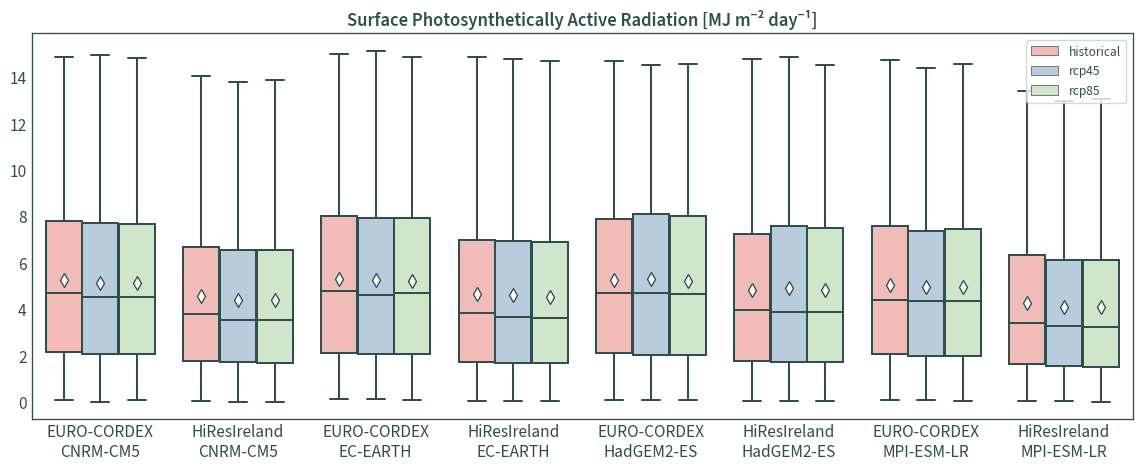

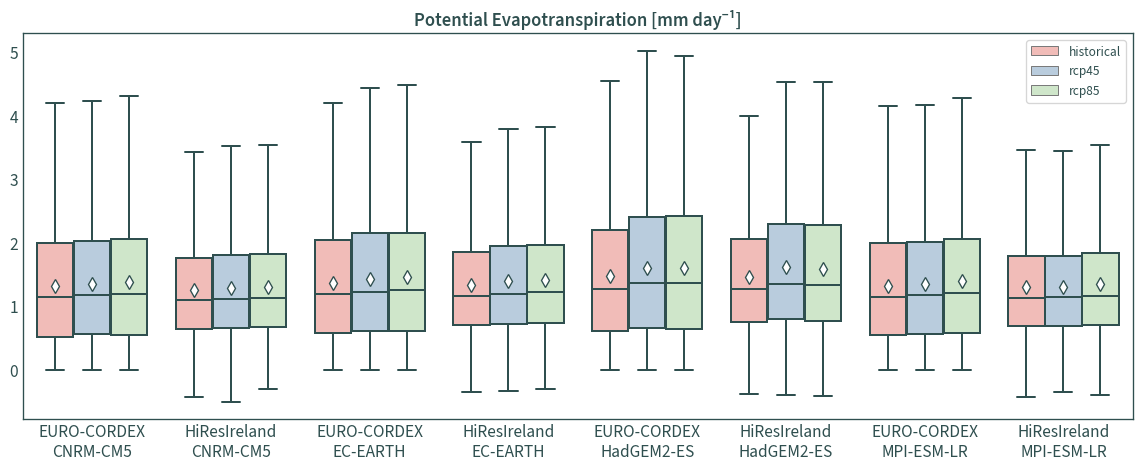

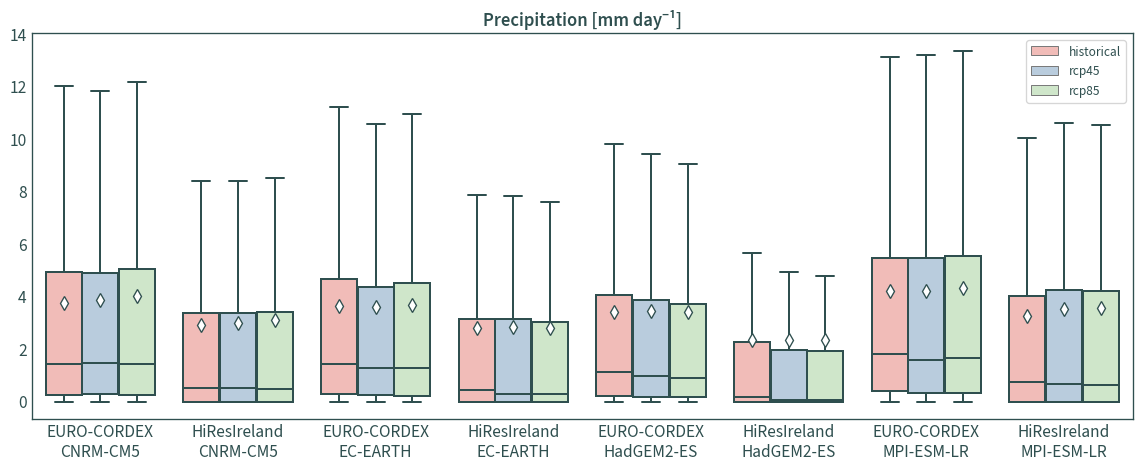

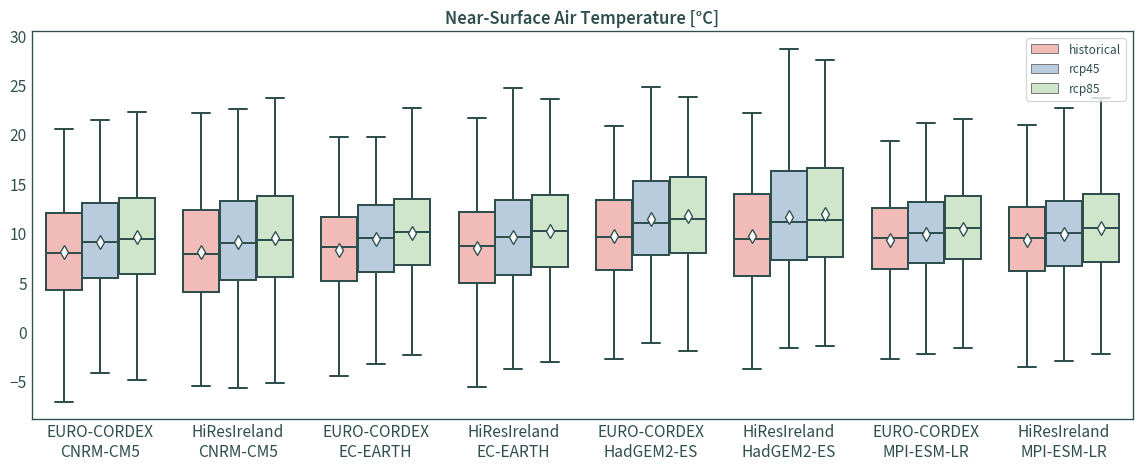

In [24]:
for var in varlist:
    climag_plot.boxplot_all(
        data=data_all[var],
        var=var,
        title=(
            datasets["EURO-CORDEX_EC-EARTH_rcp45"][var].attrs["long_name"]
            + f" [{datasets['EURO-CORDEX_EC-EARTH_rcp45'][var].attrs['units']}]"
        ),
    )

## Histograms

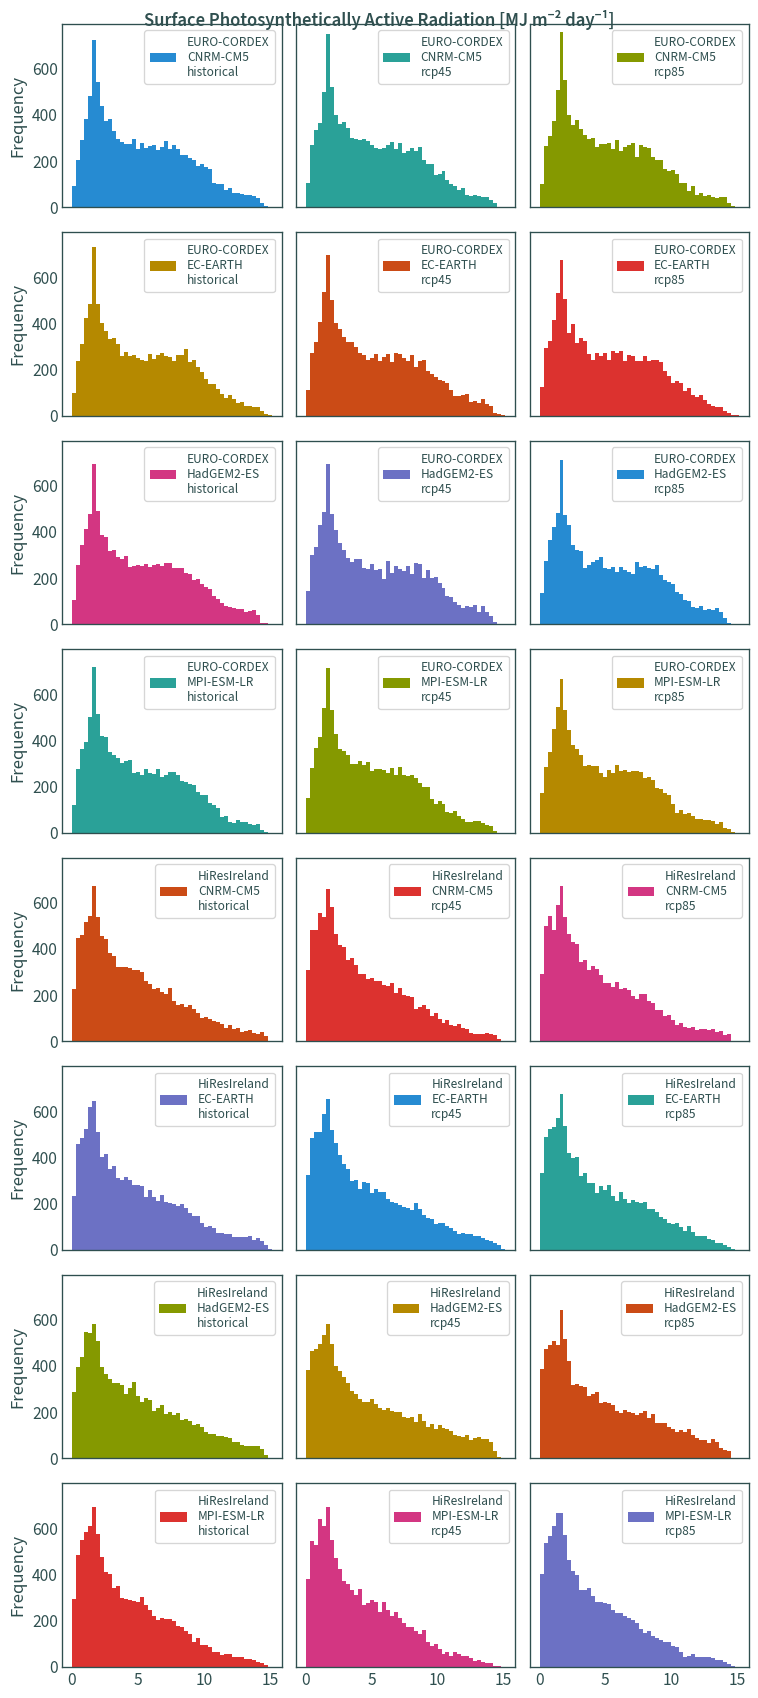

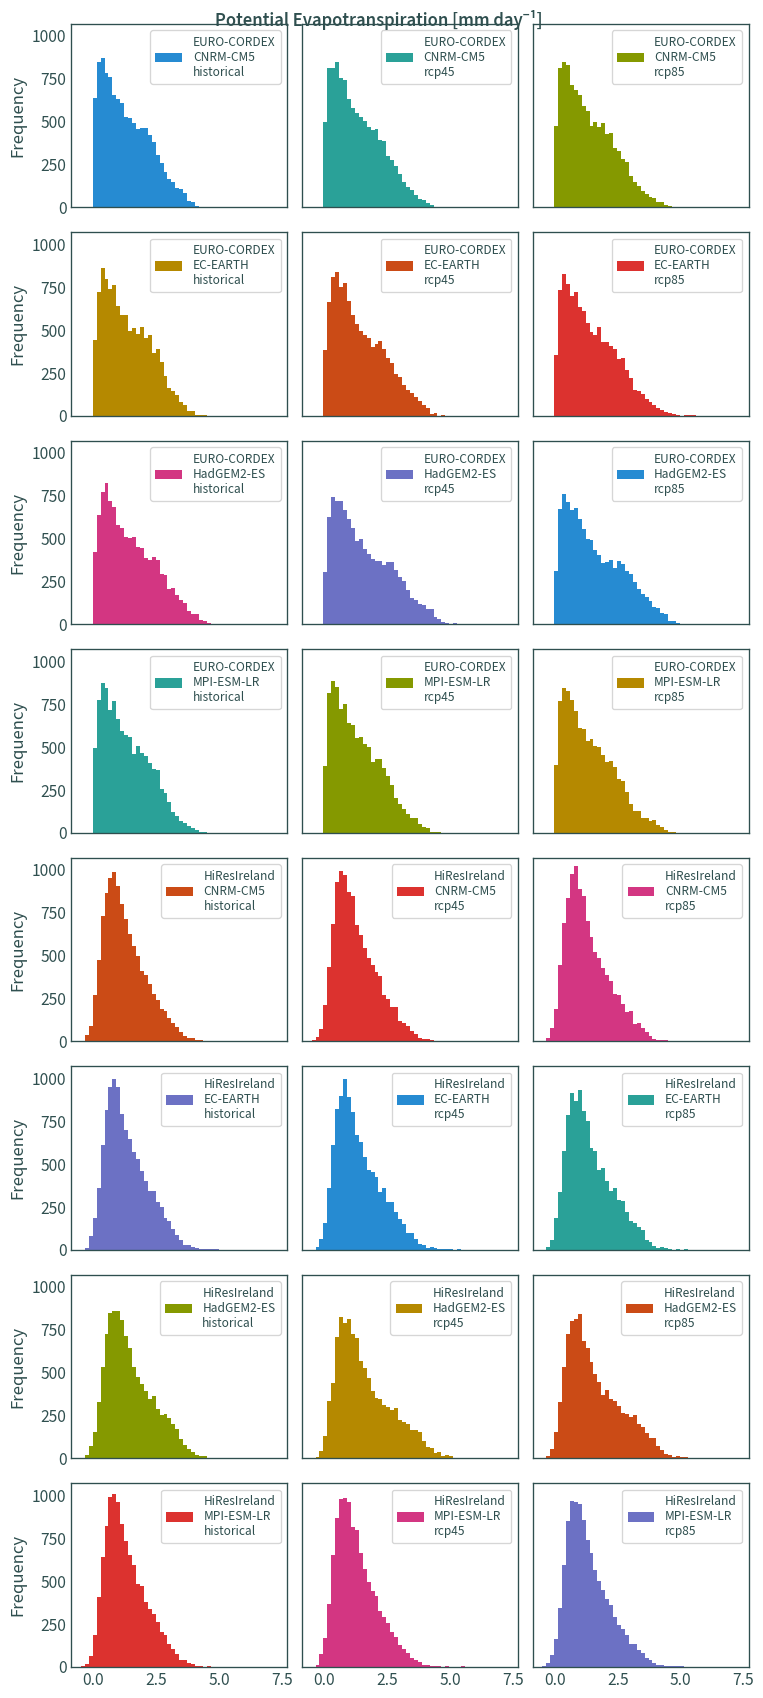

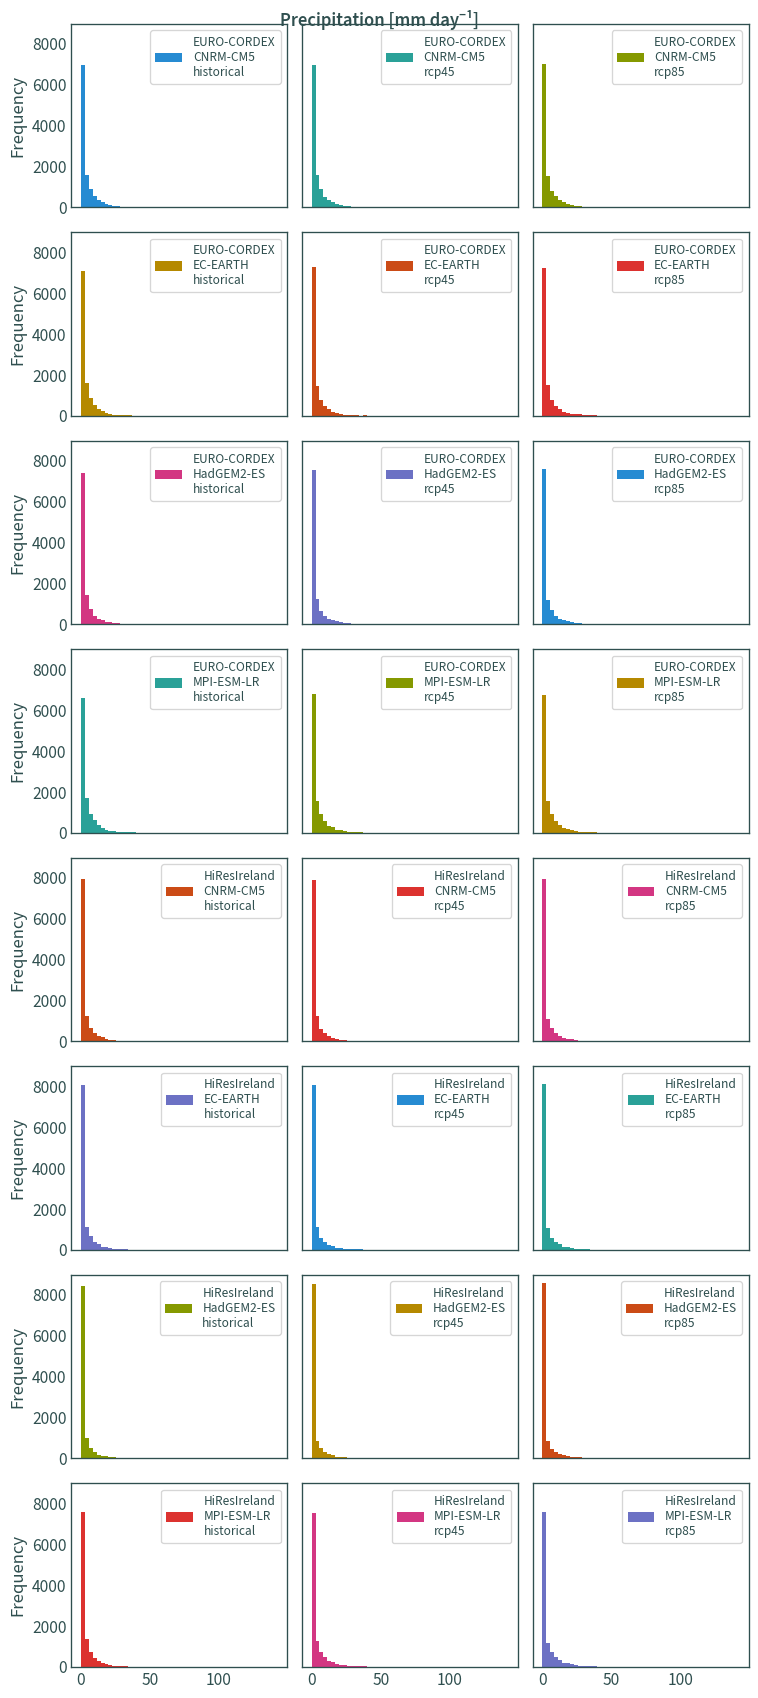

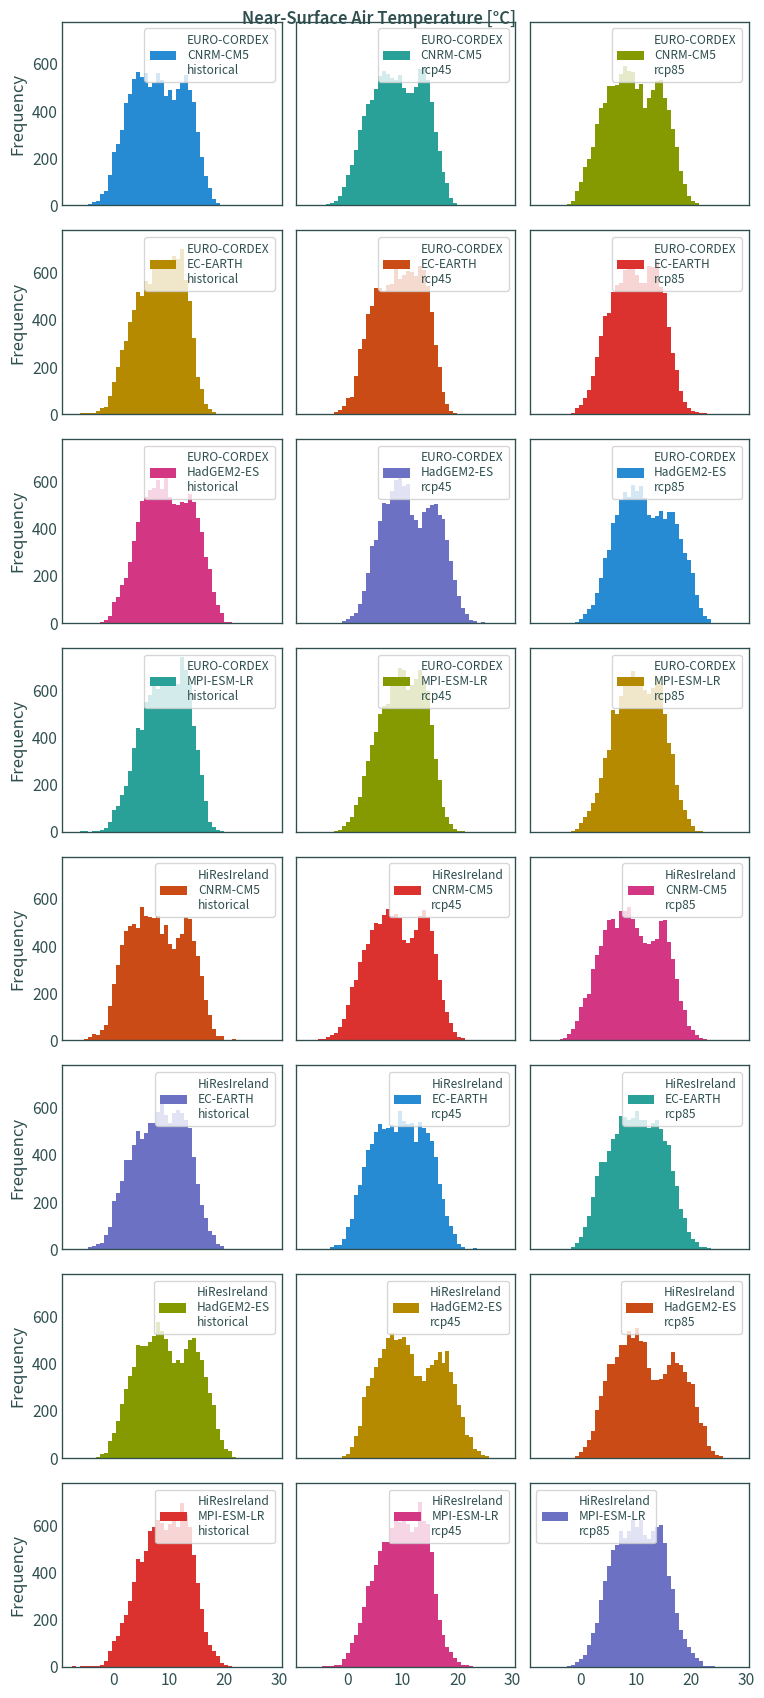

In [25]:
for var in varlist:
    data_pivot = pd.pivot_table(
        data_all[var], values=var, columns="legend", index=data_all[var].index
    )
    data_pivot.plot(
        kind="hist",
        subplots=True,
        figsize=(8, 18),
        bins=50,
        sharex=True,
        sharey=True,
        layout=(8, 3),
        title=(
            datasets["EURO-CORDEX_EC-EARTH_rcp45"][var].attrs["long_name"]
            + f" [{datasets['EURO-CORDEX_EC-EARTH_rcp45'][var].attrs['units']}]"
            # f" at Moorepark ({LON}, {LAT})"
        ),
    )
    plt.tight_layout()
    plt.show()

## Multi-model time series

In [129]:
datasets["MÉRA"] = xr.open_dataset(
    "data/MERA/IE_MERA_FC3hr_3_day.nc", decode_coords="all", chunks="auto"
)

In [130]:
datasets["MÉRA"] = datasets["MÉRA"].sel(time=slice("1981", "2018"))

In [131]:
datasets["MÉRA"].rio.write_crs(cplt.projection_lambert_conformal, inplace=True)

<xarray.Dataset>
Dimensions:            (x: 158, y: 166, time: 13879)
Coordinates:
  * x                  (x) float64 4.15e+05 4.175e+05 ... 8.05e+05 8.075e+05
  * y                  (y) float64 4.075e+05 4.1e+05 ... 8.175e+05 8.2e+05
    height             float64 ...
    Lambert_Conformal  int64 ...
  * time               (time) datetime64[ns] 1981-01-01 ... 2018-12-31
    spatial_ref        int64 0
Data variables:
    PAR                (time, y, x) float32 dask.array<chunksize=(6198, 73, 70), meta=np.ndarray>
    PET                (time, y, x) float32 dask.array<chunksize=(6198, 73, 70), meta=np.ndarray>
    T                  (time, y, x) float32 dask.array<chunksize=(6198, 73, 70), meta=np.ndarray>
    PP                 (time, y, x) float32 dask.array<chunksize=(6198, 73, 70), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...
    dataset:      IE_MERA_FC3hr_3_day

In [132]:
var_attrs = {}
for var in varlist:
    var_attrs[var] = datasets["EURO-CORDEX_CNRM-CM5_historical"][var].attrs

In [133]:
ts = {}
for key in datasets.keys():
    ts[key] = cplt.weighted_average(data=datasets[key], averages="year")
    ts[key].rio.write_crs(datasets[key].rio.crs, inplace=True)
    for var in varlist:
        ts[key][var].attrs = var_attrs[var]

In [134]:
for exp, model, data in itertools.product(
    ["historical", "rcp45", "rcp85"],
    ["CNRM-CM5", "EC-EARTH", "HadGEM2-ES", "MPI-ESM-LR"],
    ["EURO-CORDEX", "HiResIreland"],
):
    # using met station coordinates
    cds = cplt.rotated_pole_point(
        data=ts[f"{data}_{model}_{exp}"], lon=LON, lat=LAT
    )

    ts[f"{data}_{model}_{exp}"] = ts[f"{data}_{model}_{exp}"].sel(
        {"rlon": cds[0], "rlat": cds[1]}, method="nearest"
    )

In [135]:
cds = cplt.projection_lambert_conformal.transform_point(
    x=LON, y=LAT, src_crs=ccrs.PlateCarree()
)

ts["MÉRA"] = ts["MÉRA"].sel({"x": cds[0], "y": cds[1]}, method="nearest")

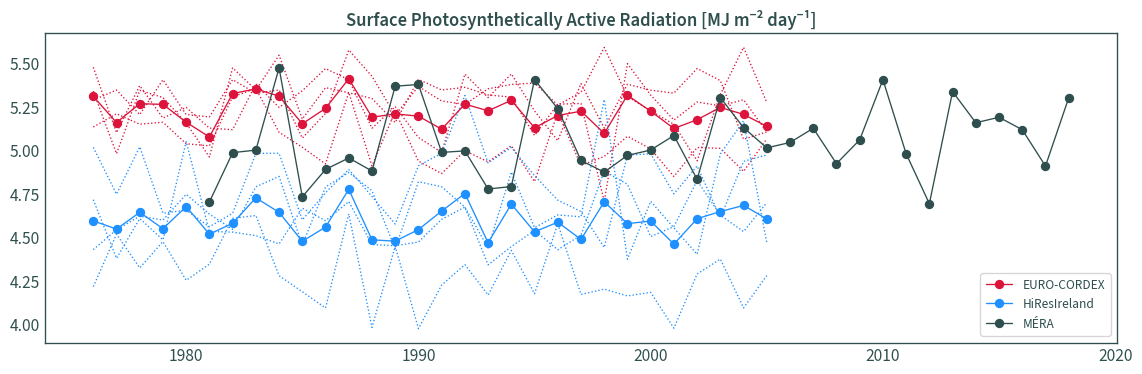

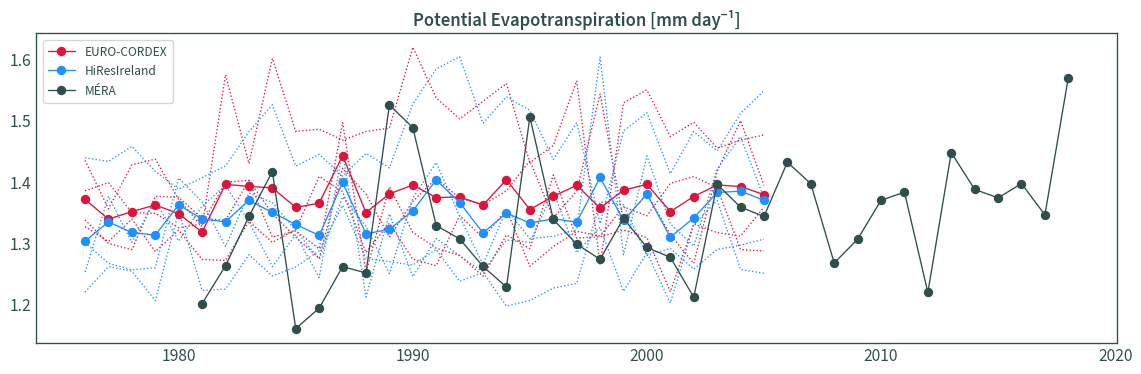

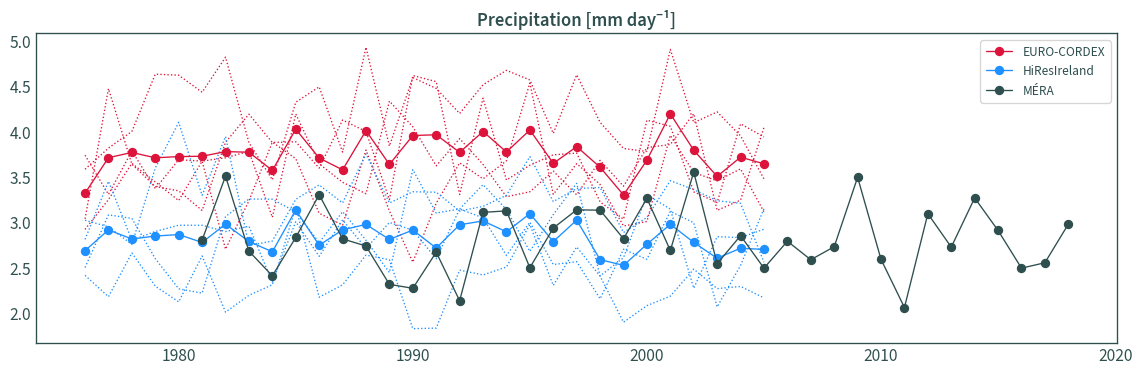

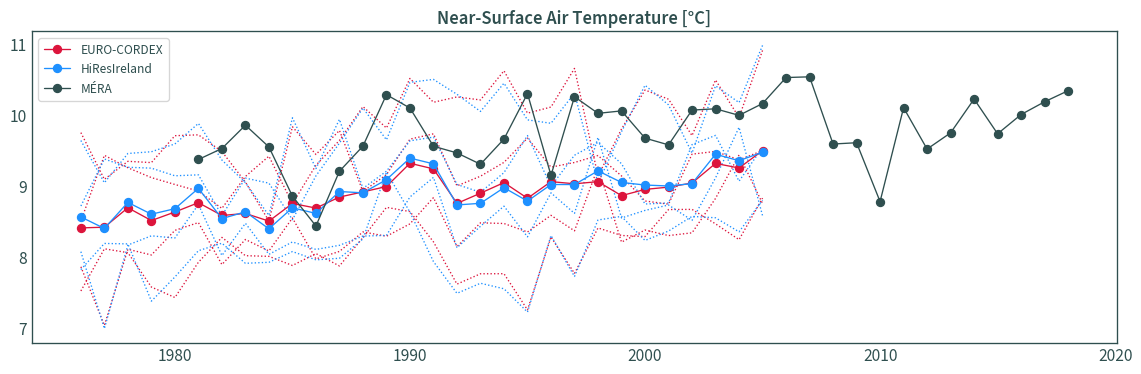

In [143]:
for var in varlist:
    df_1 = pd.DataFrame(
        {"time": ts["EURO-CORDEX_CNRM-CM5_historical"]["year"]}
    )
    df_1.set_index("time", inplace=True)
    df_2 = df_1.copy()

    for model, data in itertools.product(
        ["CNRM-CM5", "EC-EARTH", "HadGEM2-ES", "MPI-ESM-LR"],
        ["EURO-CORDEX", "HiResIreland"],
    ):
        if data == "HiResIreland":
            df_2[f"{data}_{model}_historical"] = ts[
                f"{data}_{model}_historical"
            ][var]
        else:
            df_1[f"{data}_{model}_historical"] = ts[
                f"{data}_{model}_historical"
            ][var]

    df_3 = pd.DataFrame({"time": ts["MÉRA"]["year"]})
    df_3.set_index("time", inplace=True)
    df_3["MÉRA"] = ts["MÉRA"][var]

    ax = df_1.plot(
        figsize=(12, 4),
        legend=False,
        color="crimson",
        linewidth=1,
        linestyle="dotted",
    )
    df_2.plot(
        legend=False,
        color="dodgerblue",
        ax=ax,
        linewidth=1,
        linestyle="dotted",
    )
    df_1.mean(axis=1).plot(
        color="crimson",
        label="EURO-CORDEX",
        legend=True,
        linewidth=1,
        marker="o",
    )
    df_2.mean(axis=1).plot(
        color="dodgerblue",
        label="HiResIreland",
        legend=True,
        linewidth=1,
        marker="o",
    )
    df_3.plot(color="darkslategrey", ax=ax, linewidth=1, marker="o")
    plt.xlabel("")
    plt.title(
        f"{ts['MÉRA'][var].attrs['long_name']} [{ts['MÉRA'][var].attrs['units']}]"
    )
    plt.tight_layout()
    plt.show()